# Curso BancoEstado-CMM: Aprendizaje de Máquinas Avanzado 
**Autores:** Taco de Wolff, Nicolas Caro y Felipe Tobar  

**Fecha:** 27 deciembre, 2019

# Módulo 9 - Redes Bayesianes
Instalar con `conda install pomegranate`.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy as np

from pomegranate import *

## Monty Hall
Monty Hall fue un show de juego en estados unidos que dio al concursante una elección entre tres puertas. Una puerta lleva a un auto, las otras dos a una cabra. Después elegir una puerta, el anfitrión abre una de las otras dos puertas y muestra una cabra. Te da la oportunidad de cambiar tu elección a la otra puerta o quedar con la primera elección. Que harías?

Intuitivo crees que cambiar puerta no cambia las chances. Pero en realidad te conviene cambiar la puerta porque te da una mejor chance de ganar el auto. Con redes Bayesianes podemos explorar este problema.

El problema explicado en Wikipedia: https://en.wikipedia.org/wiki/Monty_Hall_problem

### Interpretación probabilistica
Suponemos que tengamos tres variables aleatorias: Concursante $ C \in \{1, 2, 3\} $, Anfitrión $ H \in \{1, 2, 3\} $ y el premio $ P \in \{1, 2, 3 \} $. El premio en detrás una puerta aleatoria, entonces: $ P(P=1) = P(P=2) = P(P=3) = \frac{1}{3} $. Además, el concursante eleccionará una puerta aleatoriamente: $ P(C=1) = P(C=2) = P(C=3) = \frac{1}{3} $. Construimos una red Bayesiana así:

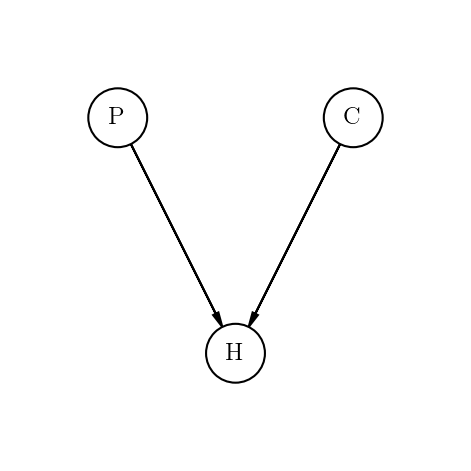

In [4]:
from IPython.display import Image
Image('monty.png')

In [17]:
# Los concursantes eligen la puerta inicialmente aleatoriamente
guest = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# La puerta con el premio es aleatorio
prize = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# El anfitrión depende del concursante y el premio 
host = ConditionalProbabilityTable(
        [[ 'A', 'A', 'A', 0.0 ],
         [ 'A', 'A', 'B', 0.5 ],
         [ 'A', 'A', 'C', 0.5 ],
         [ 'A', 'B', 'A', 0.0 ],
         [ 'A', 'B', 'B', 0.0 ],
         [ 'A', 'B', 'C', 1.0 ],
         [ 'A', 'C', 'A', 0.0 ],
         [ 'A', 'C', 'B', 1.0 ],
         [ 'A', 'C', 'C', 0.0 ],
         [ 'B', 'A', 'A', 0.0 ],
         [ 'B', 'A', 'B', 0.0 ],
         [ 'B', 'A', 'C', 1.0 ],
         [ 'B', 'B', 'A', 0.5 ],
         [ 'B', 'B', 'B', 0.0 ],
         [ 'B', 'B', 'C', 0.5 ],
         [ 'B', 'C', 'A', 1.0 ],
         [ 'B', 'C', 'B', 0.0 ],
         [ 'B', 'C', 'C', 0.0 ],
         [ 'C', 'A', 'A', 0.0 ],
         [ 'C', 'A', 'B', 1.0 ],
         [ 'C', 'A', 'C', 0.0 ],
         [ 'C', 'B', 'A', 1.0 ],
         [ 'C', 'B', 'B', 0.0 ],
         [ 'C', 'B', 'C', 0.0 ],
         [ 'C', 'C', 'A', 0.5 ],
         [ 'C', 'C', 'B', 0.5 ],
         [ 'C', 'C', 'C', 0.0 ]], [guest, prize])

# Los estados contiene la distribution y un nombre
s1 = State(guest, name="guest")
s2 = State(prize, name="prize")
s3 = State(host, name="host")

In [19]:
# Creamos la red Bayesiana
model = BayesianNetwork("Monty Hall Problem")

# Agregamos los estados (nodos de grafo) 
model.add_states(s1, s2, s3)

# Agregamos las aristas entre los nodos. El segundo nodo depende del primero nodo.
# El anfitrión depende del concursante y el premio
model.add_edge(s1, s3)
model.add_edge(s2, s3)

# Construir el modelo
model.bake()

### Calcular probabilidades
Supongamos que el concursante elige puerta A, y el anfitrión muestra puerta C. ¿Qué es la probabilidad que el premio is detrás puerta A o B, y nos conviene cambiar a puerta B?

Sí, la probabilidad que el auto es detrás puerta B es $\frac{2}{3}$ mientras la probabilidad que el auto es detrás A queda con $\frac{1}{3}$.

In [20]:
model.predict_proba({'guest': 'A', 'host': 'C'})

array(['A',
       {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "A" :0.3333333333333334,
            "B" :0.6666666666666664,
            "C" :0.0
        }
    ],
    "frozen" :false
},
       'C'], dtype=object)

¿Qué pasa si solo el anfitrión muestra puerta A aunque el concursante no elegió nada? Hay igual probabilidad que el auto es detrás B o C.

In [21]:
model.predict_proba({'host': 'A'})

array([{
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "A" :0.0,
            "B" :0.49999999999999983,
            "C" :0.49999999999999983
        }
    ],
    "frozen" :false
},
       {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "A" :0.0,
            "B" :0.49999999999999983,
            "C" :0.49999999999999983
        }
    ],
    "frozen" :false
},
       'A'], dtype=object)

## Naive Bayes
En este ejemplo mostramos un clasificador Bayes ingenuo. Tenemos la altura, el peso, y el tamaño de los pies para clasificar si la persona es masculino o feminino.

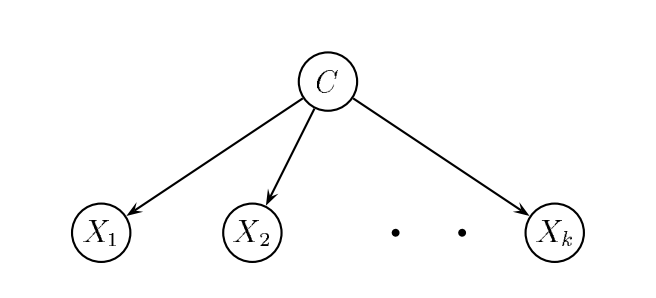

In [61]:
from IPython.display import Image
Image('naive_bayes.png')

In [59]:
male = NormalDistribution.from_samples([1.75, 1.72, 1.67, 1.81, 1.76, 1.71])
female = NormalDistribution.from_samples([1.62, 1.59, 1.54, 1.68, 1.60, 1.61])

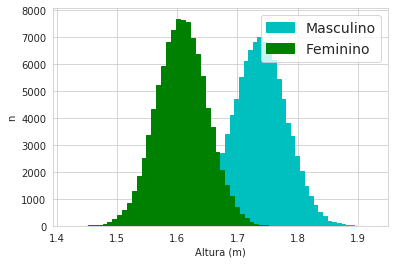

Masculino distribución tiene mu = 1.74 m y sigma = 0.044 m
Feminino distribución tiene mu = 1.61 m y sigma = 0.041 m


In [74]:
male.plot(n=100000, edgecolor='c', color='c', bins=50, label='Masculino')
female.plot(n=100000, edgecolor='g', color='g', bins=50, label='Feminino')
plt.legend(fontsize=14)
plt.ylabel('n')
plt.xlabel('Altura (m)')
plt.show()

print("Masculino distribución tiene mu = %4.2f m y sigma = %5.3f m" % (male.parameters[0], male.parameters[1]))
print("Feminino distribución tiene mu = %4.2f m y sigma = %5.3f m" % (female.parameters[0], female.parameters[1]))

`X` contiene la altura, el peso, y el tamaño de los pies para 12 personas. `y` dice `0` para un hombre y `1` para una mujer. Entrenamos nuestro modelo de Bayes ingenuo y distribuciones Gaussianes.

In [75]:
X = [
    [1.75, 70, 11],
    [1.72, 82, 12],
    [1.67, 95, 12],
    [1.81, 105, 13],
    [1.76, 85, 10],
    [1.71, 72, 11],
    [1.62, 55, 9],
    [1.59, 64, 6],
    [1.54, 59, 8],
    [1.68, 68, 7],
    [1.60, 75, 9],
    [1.61, 62, 8],
]
y = [0,0,0,0,0,0,1,1,1,1,1,1]

clf = NaiveBayes.from_samples(NormalDistribution, X, y)

In [76]:
data = np.array([[1.85, 80, 12], [1.70, 105, 11], [1.675, 69, 10], [1.65, 70, 7], [1.60, 65, 8]])

for sample, probability in zip(data, clf.predict_proba(data)):
    print("[%5.3f m, %3.0f kg, %2.0f ft]: %9.5f%% de probabilidad masculino y %9.5f%% de probabilidad feminino" % (sample[0], sample[1], sample[2], 100*probability[0], 100*probability[1]))

[1.850 m,  80 kg, 12 ft]: 100.00000% de probabilidad masculino y   0.00000% de probabilidad feminino
[1.700 m, 105 kg, 11 ft]: 100.00000% de probabilidad masculino y   0.00000% de probabilidad feminino
[1.675 m,  69 kg, 10 ft]:  52.41787% de probabilidad masculino y  47.58213% de probabilidad feminino
[1.650 m,  70 kg,  7 ft]:   0.00022% de probabilidad masculino y  99.99978% de probabilidad feminino
[1.600 m,  65 kg,  8 ft]:   0.00015% de probabilidad masculino y  99.99985% de probabilidad feminino


In [77]:
for sample, result in zip(data, clf.predict(data)):
    print("Persona con [%5.3f m, %3.0f kg, %2.0f ft] es %s." % (sample[0], sample[1], sample[2], "feminino" if result else "masculino"))

Persona con [1.850 m,  80 kg, 12 ft] es masculino.
Persona con [1.700 m, 105 kg, 11 ft] es masculino.
Persona con [1.675 m,  69 kg, 10 ft] es masculino.
Persona con [1.650 m,  70 kg,  7 ft] es feminino.
Persona con [1.600 m,  65 kg,  8 ft] es feminino.
